# Solving a Fourth Order Elliptic Singular Perturbation Problem

$$
\left\{\begin{array}{lr}
\varepsilon^{2} \Delta^{2} u-\Delta u=f & \text { in } \Omega \\
u=\partial_{n} u=0 & \text { on } \partial \Omega
\end{array}\right.
$$

## Problem 3
Now let's move to the next stage:
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right)&=\left(f, \chi_{h}\right) \\
\left(\operatorname{curl}_{h} z_{h}, \operatorname{curl}_{h} v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) \\
\left(\phi_{h}, \psi_{h}\right)+\varepsilon^{2}\left(\nabla_{h} \phi_{h}, \nabla_{h} \psi_{h}\right)+\left(\operatorname{div}_{h} \psi_{h}, p_{h}\right) &=\left(\operatorname{curl}_{h} z_{h}, \psi_{h}\right) \\
\left(\operatorname{div}_{h} \phi_{h}, q_{h}\right) &=0 \\
\left(\operatorname{curl}_{h} u_{h 0}, \operatorname{curl}_{h} \chi_{h}\right) &=\left(\phi_{h}, \operatorname{curl}_{h} \chi_{h}\right)
\end{aligned}
$$

In [1]:
from skfem import *
import numpy as np
from utils import solver_iter_krylov, solver_iter_pyamg, solver_iter_mgcg, solver_iter_mgcg_iter, solver_iter_krylov_iter
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod, div, curl
from scipy.sparse.linalg import LinearOperator, minres, aslinearoperator
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
from skfem.visuals.matplotlib import draw, plot
import scipy.sparse.linalg as spl
from scipy.sparse import bmat, hstack, vstack
from scipy import sparse
from skfem.visuals.matplotlib import draw, plot
import datetime
import pandas as pd
import sys
import time
import pyamg

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

# parameters

tol = 1e-8
intorder = 4
solver_type = 'mgcg'
refine_time = 5
epsilon_range = 4
zero_ep = False
element_type = 'P1'
sigma = 5
penalty = True
example = 'ex2'

## Forms and errors

In [17]:
@BilinearForm
def phipsi_load1(u, v, w):
    '''
    for 5.7b $(phi, psi)$
    '''
    return dot(u, v)

@BilinearForm
def phipsi_load2(u, v, w):
    '''
    for 5.7b $(Laplace_phi, Laplace_psi)$
    '''
    return ddot(grad(u), grad(v))


@BilinearForm
def phipsi_load3(u, v, w):
    '''
    for 5.7b $(div_phi, p)$
    '''
    return div(u) * v


@BilinearForm
def zpsi_load(u, v, w):
    '''
    for 5.7b $(curl_z, psi)$
    '''
    return dot(curl(u), v)


@BilinearForm
def phiq_load(u, v, w):
    '''
    for 5.7c $(div_phi, q)$
    '''
    return div(u) * v


@BilinearForm
def mass(u, v, w):
    '''
    for 5.7c C
    '''
    return u * v 

@BilinearForm
def phichi_load(u, v, w):
    '''
    for 5.7d $(phi, curl_chi)$
    '''
    return dot(u, curl(v))

@BilinearForm
def uchi_load(u, v, w):
    '''
    for 5.7d $(curl_u, curl_chi)$
    '''
    return dot(curl(u), curl(v))

In [18]:
@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))


@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates(
    ).value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

@BilinearForm
def zv_load(u, v, w):
    '''
    for 5.7a
    '''
    return dot(curl(u), curl(v))

In [4]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D

class ElementTriCR(ElementH1):
    
    facet_dofs = 1
    dim = 2
    maxdeg = 1
    dofnames = ['u']
    doflocs = np.array([[.5, 0.], [.5, .5], [0., .5]])
    mesh_type = MeshTri

    def lbasis(self, X, i):
        x, y = X

        if i == 0:
            phi = 1. - 2. * y
            dphi = np.array([0. * x, -2. + 0. * y])
        elif i == 1:
            phi = 2. * x + 2. * y - 1.
            dphi = np.array([2. + 0. * x, 2. + 0. * y])
        elif i == 2:
            phi = 1. - 2. * x
            dphi = np.array([-2. + 0. * x, 0. * x])
        else:
            self._index_error()
        return phi, dphi

In [12]:
@BilinearForm
def a_load(u, v, w):
    '''
    for $a_{h}$
    '''
    return ddot(dd(u), dd(v))


@BilinearForm
def b_load(u, v, w):
    '''
    for $b_{h}$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def wv_load(u, v, w):
    '''
    for $(\nabla \chi_{h}, \nabla_{h} v_{h})$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def penalty_1(u, v, w):
    return ddot(-dd(u), prod(w.n, w.n)) * dot(grad(v), w.n)


@BilinearForm
def penalty_2(u, v, w):
    return ddot(-dd(v), prod(w.n, w.n)) * dot(grad(u), w.n)


@BilinearForm
def penalty_3(u, v, w):
    return (sigma / w.h) * dot(grad(u), w.n) * dot(grad(v), w.n)


@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))

## Testing convergence

In [201]:
from scipy import integrate

In [197]:
tol = 1e-5
intorder = 19
solver_type = 'mgcg'
refine_time = 7
epsilon_range = 3
zero_ep = False
element_type = 'P1'
sigma = 5
penalty = False
example = 'ex2'

In [198]:
if example == 'ex1':

    @LinearForm
    def f_load(v, w):
        '''
        for $(f, x_{h})$
        '''
        pix = pi * w.x[0]
        piy = pi * w.x[1]
        lu = 2 * (pi)**2 * (cos(2 * pix) * ((sin(piy))**2) + cos(2 * piy) *
                            ((sin(pix))**2))
        llu = -8 * (pi)**4 * (cos(2 * pix) * sin(piy)**2 + cos(2 * piy) *
                            sin(pix)**2 - cos(2 * pix) * cos(2 * piy))
        return (epsilon**2 * llu - lu) * v


    def exact_u(x, y):
        return (sin(pi * x) * sin(pi * y))**2


    def dexact_u(x, y):
        dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
        duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
        return dux, duy


    def ddexact(x, y):
        duxx = 2 * pi**2 * cos(pi * x)**2 * sin(pi * y)**2 - 2 * pi**2 * sin(
            pi * x)**2 * sin(pi * y)**2
        duxy = 2 * pi * cos(pi * x) * sin(pi * x) * 2 * pi * cos(pi * y) * sin(
            pi * y)
        duyx = duxy
        duyy = 2 * pi**2 * cos(pi * y)**2 * sin(pi * x)**2 - 2 * pi**2 * sin(
            pi * y)**2 * sin(pi * x)**2
        return duxx, duxy, duyx, duyy

elif example == 'ex2':

    @LinearForm
    def f_load(v, w):
        '''
        for $(f, x_{h})$
        '''
        x = w.x[0]
        y = w.x[1]
        return (
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            (12 * y + ep *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) -
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - ep**2 *
            (((pi**4 * sin(pi * x)) / 2 - (ep * pi * (exp(-x / ep) / ep**4 + exp(
                (x - 1) / ep) / ep**4)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                    (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                    (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                    (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - 2 *
            (12 * y + ep *
            ((exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) *
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) + ep *
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**4 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**4))) * v


    def exact_u(x, y):
        return -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                                (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                                (3 * exp(-1 / ep) + 3) /
                                                (exp(-1 / ep) - 1) -
                                                ((2 * y - 1) *
                                                (exp(-1 / ep) - 1)) /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))


    def dexact_u(x, y):
        dux = -((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
            (x - 1) / ep) / ep)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))
        duy = (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
            (2 * (exp(-1 / ep) - 1))) * (ep * (
                (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1) +
                (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep -
                (exp((y - 1) / ep) *
                    (3 / (exp(-1 / ep) - 1) - 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
        return dux, duy


    def ddexact(x, y):
        duxx = ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
            (x - 1) / ep) / ep**2)) /
                (2 *
                (exp(-1 / ep) - 1))) * (ep * (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                                (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                                (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                        (y**2 - 1))
        duxy = ((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
            (x - 1) / ep) / ep)) / (2 * (exp(-1 / ep) - 1))) * (ep * (
                (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1) +
                (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                (exp(-1 / ep) + 2 * ep *
                                (exp(-1 / ep) - 1) + 1))) / ep -
                (exp((y - 1) / ep) *
                (3 / (exp(-1 / ep) - 1) - 1 /
                (exp(-1 / ep) + 2 * ep *
                (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
        duyx = duxy
        duyy = -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) /
                (2 *
                (exp(-1 / ep) - 1))) * (12 * y + ep *
                                        ((exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1))) / ep**2 +
                                        (exp((y - 1) / ep) *
                                            (3 / (exp(-1 / ep) - 1) - 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1))) / ep**2))
        return duxx, duxy, duyx, duyy

else:
    raise Exception('Example not supported')

In [209]:
@Functional
def f_square(w):
    x, y = w.x
    return (
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            (12 * y + ep *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) -
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - ep**2 *
            (((pi**4 * sin(pi * x)) / 2 - (ep * pi * (exp(-x / ep) / ep**4 + exp(
                (x - 1) / ep) / ep**4)) / (2 * (exp(-1 / ep) - 1))) *
            (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                        (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                    (3 / (exp(-1 / ep) - 1) + 1 /
                    (exp(-1 / ep) + 2 * ep *
                    (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                    (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                    (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
            (y**2 - 1)) - 2 *
            (12 * y + ep *
            ((exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**2)) *
            ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
                (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) + ep *
            (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
                (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
            ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**4 + (exp(
                    (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**4)))**2

In [210]:
func = lambda x, y: (
    (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
        (x - 1) / ep) - exp(-1 / ep) - 1)) /
     (2 * (exp(-1 / ep) - 1))) * (12 * y + ep * (
         (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                          (exp(-1 / ep) + 2 * ep *
                           (exp(-1 / ep) - 1) + 1))) / ep**2 +
         (exp((y - 1) / ep) *
          (3 / (exp(-1 / ep) - 1) - 1 /
           (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2)) -
    ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
        (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) *
    (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                (exp(-1 / ep) + 2 * ep *
                                 (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
           (3 / (exp(-1 / ep) - 1) + 1 / (exp(-1 / ep) + 2 * ep *
                                          (exp(-1 / ep) - 1) + 1)) -
           (3 * exp(-1 / ep) + 3) / (exp(-1 / ep) - 1) - ((2 * y - 1) *
                                                          (exp(-1 / ep) - 1)) /
           (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
     (y**2 - 1)) - ep**2 *
    (((pi**4 * sin(pi * x)) / 2 - (ep * pi * (exp(-x / ep) / ep**4 + exp(
        (x - 1) / ep) / ep**4)) / (2 * (exp(-1 / ep) - 1))) *
     (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                 (exp(-1 / ep) + 2 * ep *
                                  (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
             (exp(-1 / ep) + 2 * ep *
              (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
            (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
            (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
      (y**2 - 1)) - 2 * (12 * y + ep * (
          (exp(-y / ep) *
           (3 / (exp(-1 / ep) - 1) + 1 /
            (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                 (exp(-1 / ep) + 2 * ep *
                                  (exp(-1 / ep) - 1) + 1))) / ep**2)) *
     ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
         (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) + ep *
     (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
         (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) * (
             (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                              (exp(-1 / ep) + 2 * ep *
                               (exp(-1 / ep) - 1) + 1))) / ep**4 +
             (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                   (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1))) / ep**4)))**2

In [ ]:
epsilon = 0.001
ep = epsilon

In [243]:
intorder = 19

In [270]:
for j in range(5):
    m = MeshTri()
    refines = j
    m.refine(refines)
    element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    basis = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element.items()}

    # K1 = asm(laplace, basis['w'])
    # f1 = asm(f_load, basis['w'])
    # wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
    wh = np.zeros((2**refines +1)**2)

    W = basis['w'].interpolate(wh).value
    print('h = 2^-{} \n'.format(refines))
    for i in range(5):
        epsilon = 10**(-i)
        ep = ep = epsilon

        F_L2 = np.sqrt(f_square.assemble(basis['w'], w=W))

        print('epsilon = {}'.format(epsilon))
        print('Gauss: {}'.format(F_L2))
        print('dblquad: ', np.sqrt(integrate.dblquad(func, 0, 1, 0, 1)), '\n')

h = 2^-0 

epsilon = 1
Gauss: 1.146301026385355
dblquad:  [1.14630103e+00 1.71348689e-07] 

epsilon = 0.1
Gauss: 2.7632248182686454
dblquad:  [2.76323744e+00 3.00454697e-04] 

epsilon = 0.01
Gauss: 4.003364580960405
dblquad:  [4.00432714e+00 6.28587755e-04] 

epsilon = 0.001
Gauss: 4.1762618220480165
dblquad:  [4.17626312e+00 4.63387141e-04] 

epsilon = 0.0001
Gauss: 4.194030109698591
dblquad:  [4.19403011e+00 5.76447043e-07] 

h = 2^-1 

epsilon = 1
Gauss: 1.1463010263821092
dblquad:  [1.14630103e+00 1.71348689e-07] 

epsilon = 0.1
Gauss: 2.763237439059776
dblquad:  [2.76323744e+00 3.00454697e-04] 

epsilon = 0.01
Gauss: 4.003933558488798
dblquad:  [4.00432714e+00 6.28587755e-04] 

epsilon = 0.001
Gauss: 4.176256466309968
dblquad:  [4.17626312e+00 4.63387141e-04] 

epsilon = 0.0001
Gauss: 4.194030109697141
dblquad:  [4.19403011e+00 5.76447043e-07] 

h = 2^-2 

epsilon = 1
Gauss: 1.1463010263821047
dblquad:  [1.14630103e+00 1.71348689e-07] 

epsilon = 0.1
Gauss: 2.7632374418570658
dblq

In [269]:
m = MeshTri()
refines = 5
m.refine(refines)
element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
basis = {variable: InteriorBasis(m, e, intorder=intorder) for variable, e in element.items()}

# K1 = asm(laplace, basis['w'])
# f1 = asm(f_load, basis['w'])
# wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
wh = np.zeros((2**refines +1)**2)

W = basis['w'].interpolate(wh).value
print('h = 2^-{} \n'.format(refines))
for i in range(5):
    epsilon = 10**(-i)
    ep = ep = epsilon

    F_L2 = np.sqrt(f_square.assemble(basis['w'], w=W))
    
    print('epsilon = {}'.format(epsilon))
    print('Gauss: {}'.format(F_L2))
    print('dblquad: ', np.sqrt(integrate.dblquad(func, 0, 1, 0, 1)), '\n')

h = 2^-5 

epsilon = 1
Gauss: 1.1463010263821019
dblquad:  [1.14630103e+00 1.71348689e-07] 

epsilon = 0.1
Gauss: 2.7632374418571057
dblquad:  [2.76323744e+00 3.00454697e-04] 

epsilon = 0.01
Gauss: 4.004327142581529
dblquad:  [4.00432714e+00 6.28587755e-04] 

epsilon = 0.001
Gauss: 4.176262085229375
dblquad:  [4.17626312e+00 4.63387141e-04] 

epsilon = 0.0001
Gauss: 4.194029995834004
dblquad:  [4.19403011e+00 5.76447043e-07] 



In [254]:
F_L2

4.176262085229375

In [242]:
func(0.9999999999999999, 0.99)

18.260874647767324

In [272]:
np.sqrt(integrate.dblquad(func, 0, 1, 0, 1))[0].dtype

dtype('float64')

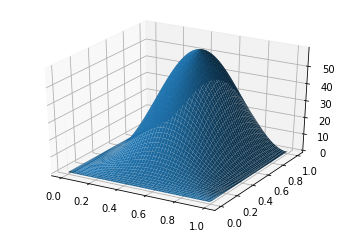

In [257]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()  
ax3 = plt.axes(projection='3d')

xx = np.arange(0, 1, 0.001)
yy = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(xx, yy)
Z = func(X, Y)

ax3.plot_surface(X, Y, Z)
#ax3.contour(X,Y,Z, zdim='z',offset=-2，cmap='rainbow)   #等高线图，要设置offset，为Z的最小值
plt.show()